#### Example of text classification with word embeddings generated through FastText.

Reference pages:
- https://radimrehurek.com/gensim/models/fasttext.html

The finance complaints dataset was preprocessed in **finance complaints dataset analysis** notebook.

Loading balanced dataset.

In [1]:
import pandas as pd
df = pd.read_csv('complaints-balanced.csv')
df.head()

,Unnamed: 0,Product,Consumer_complaint_narrative,category_id
0,0,"Credit reporting, credit repair services, or o...",My XXXX XXXX Account Was Paid Off But They Hav...,0
1,1,"Credit reporting, credit repair services, or o...",I had a citibank checking account which I clos...,0
2,2,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...,0
3,3,"Credit reporting, credit repair services, or o...",Account from XXXX with a balance is reporting ...,0
4,4,"Credit reporting, credit repair services, or o...",The credit bureaus are reporting inaccurate/ou...,0


In [2]:
print(df.isnull().sum())

Unnamed: 0                      0
Product                         0
Consumer_complaint_narrative    0
category_id                     0
dtype: int64


Text preprocessing

In [3]:
%%time
import re
from nltk.corpus import stopwords

text = df.Consumer_complaint_narrative

# removing XXX words
text = text.apply(lambda x: re.sub(r'X*', '', x))

# converting to lower case
text = text.apply(lambda x: x.lower())

# replacing symbols with spaces
text = text.apply(lambda x: re.sub(r'[/(){}\[\]\|@,;.?]', ' ', x))

# removing bad symbols
text = text.apply(lambda x: re.sub(r'[^0-9a-z #+_]', '', x))

# removing numbers
text = text.apply(lambda x: re.sub(r'\d+', '', x))

# tokenizing
text = text.apply(lambda x: x.split())

# stop words removal
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words
text = text.apply(lambda x: remove_stopwords(x))

text.head()

CPU times: user 1min 37s, sys: 8.54 s, total: 1min 45s
Wall time: 1min 46s


0    [account, paid, left, wrong, information, cred...
1    [citibank, checking, account, closed, showing,...
2    [would, like, request, suppression, following,...
3    [account, balance, reporting, credit, report, ...
4    [credit, bureaus, reporting, inaccurate, outda...
Name: Consumer_complaint_narrative, dtype: object

In [4]:
def print_example(index):
    print("-"*50)
    print("* BEFORE: {}".format(df.Consumer_complaint_narrative[index]))
    print("\n* AFTER: {}\n".format( ' '.join(w for w in text[index]) ))

print_example(0)
print_example(10)
print_example(50)

--------------------------------------------------
* BEFORE: My XXXX XXXX Account Was Paid Off But They Have Left The Wrong Information On My Credit Report For 11 Years The Account Should Be Removed It Is Too OldAnd A Medical Account That I Believed To Be Payed Off Has Also Been Left On My Report

* AFTER: account paid left wrong information credit report years account removed oldand medical account believed payed also left report

--------------------------------------------------
* BEFORE: Please be advised this is my THIRD WRITTEN REQUEST and FINAL WARNING that I fully intend to pursue litigation in accordance with the FCRA to enforce my rights and seek relief and recover all monetary damages that I may be entitled to under Section 616 and Section 617 regarding your continued willful and negligent noncompliance.

Despite two written requests, the unverified items listed below still remain on my credit report in violation of Federal Law. You are required under the FCRA to have a copy

Creating train and test sets, with balanced frequency of classes.

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, 
                             test_size=0.3, 
                             random_state=0)
for train_index, test_index in sss.split(text, df['category_id']):
    train_set = text.loc[train_index]
    train_labels = df['category_id'].loc[train_index]
    test_set = text.loc[test_index]
    test_labels = df['category_id'].loc[test_index]

Creating word embeddings.

FastText parameters:
- `size=n` - Dimensionality of the word vectors.
- `window=n` - The maximum distance between the current and predicted word within a sentence.
- `min_count=n` - The model ignores all words with total frequency lower than this.

In [6]:
%%time
import gensim

word_model = gensim.models.FastText(size=300, window=5, min_count=2)
word_model.build_vocab(sentences=train_set)
word_model.train(sentences=train_set, total_examples=len(train_set), epochs=10)

CPU times: user 1min 51s, sys: 13.6 s, total: 2min 4s
Wall time: 2min 3s


In [7]:
word_model.wv.most_similar(positive='quality')

[('eligibility', 0.9690967798233032),
 ('inability', 0.922464907169342),
 ('utility', 0.9135854840278625),
 ('preliminary', 0.913479208946228),
 ('ability', 0.911803662776947),
 ('hostility', 0.911770224571228),
 ('equity', 0.9095401763916016),
 ('liability', 0.8996611833572388),
 ('duty', 0.8926994800567627),
 ('pretty', 0.8918366432189941)]

Each document must be converted to a vector. So, we'll use the mean vector of its words.

In [8]:
import numpy as np

def word_averaging(model, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in model.wv.vocab:
            mean.append(model.wv.vectors_norm[model.wv.vocab[word].index])
            all_words.add(model.wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(model.layer1_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(model, text_list):
    return np.vstack([word_averaging(model, review) for review in text_list ])

In [9]:
%%time
X_train_word_average = word_averaging_list(word_model, train_set)
X_test_word_average = word_averaging_list(word_model, test_set)

CPU times: user 1.19 s, sys: 84.8 ms, total: 1.28 s
Wall time: 1.95 s


Let's train and evaluate some classifiers.

In [10]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.neural_network import MLPClassifier

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LogisticRegression(solver='lbfgs', max_iter=200, multi_class='auto', random_state=0),
    svm.LinearSVC(random_state=0),
    MLPClassifier(max_iter=1000, random_state=0)
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train_word_average, train_labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

CPU times: user 1min 49s, sys: 1.02 s, total: 1min 50s
Wall time: 1min 1s


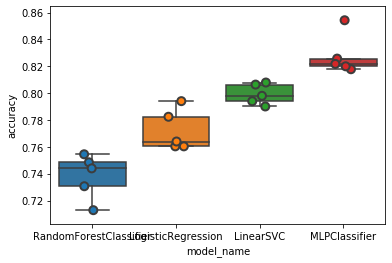

In [11]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [12]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.799285
LogisticRegression        0.772257
MLPClassifier             0.827928
RandomForestClassifier    0.738114
Name: accuracy, dtype: float64

Best model evaluation

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix

my_tags = df.category_id.unique()
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions, labels=my_tags)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

accuracy 0.8035217794253939
confusion matrix
 [[165  26  10  12   3]
 [ 26 165  14   7   4]
 [ 13  11 161   2  28]
 [  5   4   7 194   6]
 [  2   2  25   5 182]]
(row=expected, col=predicted)
CPU times: user 32.6 s, sys: 283 ms, total: 32.9 s
Wall time: 16.4 s


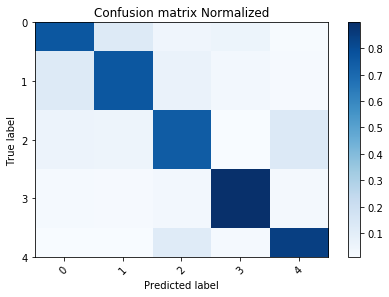

In [16]:
%%time
model = models[3]
model.fit(X_train_word_average, train_labels)
predicted = model.predict(X_test_word_average)
evaluate_prediction(predicted, test_labels)